## Train CNN and Bi LSTM Model

In [1]:
# !pip3 install fastText

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tqdm import tqdm
import nltk

##### Phase 1 : 
train =  Kirk train + kirk validation (5316 messages) \
test = TikTok + YouTube dataset (200 messages)

In [2]:
df_train = pd.concat([pd.read_csv("../Dataset/Kirk_Dataset/train.csv"), pd.read_csv("../Dataset/Kirk_Dataset/validation.csv")])
df_train = df_train.reset_index(drop=True)
df_test = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")

##### Phase 2 : 
train =  Kirk train + kirk validation (5908 messages) \
test = TikTok + YouTube dataset (200 messages)

In [3]:
df_train = pd.concat([pd.read_csv("../Dataset/Kirk_Dataset/train.csv"), pd.read_csv("../Dataset/Kirk_Dataset/test.csv")])

df_train = df_train.reset_index(drop=True)
df_test = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")

In [4]:
# extract X and Y for training from Krik dataset
X_train = df_train["text"]
Y_train = df_train["label_gold"]

In [5]:
# convert label in test set to index (Hated==1 and Non-Hated==0)
Y_test = []
X_test = df_test["Comment"]
for i in df_test["Tag_Nalin"]:
  if i == "Hated":
    Y_test.append(1)
  else:
    Y_test.append(0)

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/srunnalin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# apply word tokenize using nltk
import collections
from nltk import word_tokenize
token2int = collections.defaultdict(lambda: len(token2int)+1)
tokenized_X_train = [word_tokenize(text) for text in X_train]
tokenized_X_test = [word_tokenize(text) for text in X_test]
int_X_train = [[token2int[token.lower()] for token in text] for text in tokenized_X_train]
int_X_test = [[token2int[token.lower()] for token in text] for text in tokenized_X_test]

In [8]:
int2token = dict()
for key, value in token2int.items():
    int2token[value] = key

## Vocabulary Size:
print("The Vocabulary size is:",len(token2int))

## Maximum text length
X_train_lengths = [len(text) for text in tokenized_X_train]
X_test_lengths = [len(text) for text in tokenized_X_test]
print("The maximum text length:", max(X_train_lengths))

The Vocabulary size is: 5963
The maximum text length: 55


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# convert dataset to tensor
max_len = 55

X_train = torch.zeros(len(X_train), max_len, dtype=torch.long)

for i, int_text in enumerate(int_X_train):
    if len(int_text) < max_len:
        int_text = int_text + [len(token2int)] * (max_len - len(int_text))

    X_train[i] = torch.LongTensor(int_text[:max_len])


Y_train = torch.LongTensor(Y_train)

print(X_train.size())
print(Y_train.size())

X_test = torch.zeros(len(X_test), max_len, dtype=torch.long)

for i, int_text in enumerate(int_X_test):
    if len(int_text) < max_len:
        int_text = int_text + [len(token2int)] * (max_len - len(int_text))

    X_test[i] = torch.LongTensor(int_text[:max_len])


Y_test = torch.LongTensor(Y_test)


print(X_test.size())
print(Y_test.size())

torch.Size([5317, 55])
torch.Size([5317])
torch.Size([200, 55])
torch.Size([200])


In [11]:
X_valid = X_test
Y_valid = Y_test

In [12]:
from torch.utils.data import TensorDataset, DataLoader
# batch_size = 32
batch_size = 64
# the TensorDataset is a ready to use class to represent data as list of tensors. 
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def perf(model, loader):
    y_pred_list = []
    y_true_list = []
    ## Define the loss
    criterion = nn.CrossEntropyLoss()

    ## No drop out
    model.eval()
    total_loss, correct, num = 0, 0, 0
    correct_predictions, total_predictions = 0, 0
    for x, y in loader:
      # print("this is x:", x)
      # print(x.shape)
      ## No gradient computation, weights remain unchanged
      with torch.no_grad():
        ## Compute the scofed for the instances in the input batch.
        y_scores = model(x)
        ## compute the loss
        predictions = torch.argmax(y_scores, dim=1)
        ## compute the predictions
        correct_predictions += sum(predictions == y).item()

        total_predictions += len(y) 
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        # print("y_pred:", y_pred)
        ## Update the batch loss.
        total_loss += loss.item()
        num += len(y)
        y_pred_list.extend(y_pred.tolist())
        y_true_list.extend(y.tolist())

    return total_loss / num, correct_predictions / total_predictions, y_pred_list, y_true_list

In [14]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)  # Learning rate scheduler

    train_losses = []  # List to store training losses
    valid_losses = []  # List to store validation losses
    best_f1_score = 0
    early_stop_counter = 0
    best_model_state_dict = None  # Variable to store the state_dict of the best model
    best_epoch = 0  # Variable to store the epoch when the best model was saved

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_samples = 0
        
        for x_data, y_data in train_loader:
            x_data = x_data.to(device)
            y_data = y_data.to(device)
            optimizer.zero_grad()
            y_pred = model(x_data)
            num_samples += len(y_pred)
            loss = criterion(y_pred, y_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        valid_loss, valid_acc, y_pred_list, y_true_list = perf(model, valid_loader)
        train_loss = total_loss / num_samples
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Epoch {epoch + 1}/{epochs} | Train loss: {total_loss/num_samples:.4f} | Valid loss: {valid_loss:.4f} | Acc: {valid_acc:.4%}')
        print('Classification Report:')
        print(classification_report(y_true_list, y_pred_list, labels=[1, 0], digits=4))

        cm = confusion_matrix(y_true_list, y_pred_list, labels=[1, 0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
        disp.plot()
        plt.show()

        scheduler.step(valid_loss)  # Adjust learning rate based on validation loss

        # Calculate F1 score
        y_true = torch.tensor(y_true_list)
        y_pred = torch.tensor(y_pred_list)
        f1 = f1_score(y_true, y_pred, labels=[1, 0], average='weighted')
        # print(f"F1 score: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            early_stop_counter = 0
            best_model_state_dict = model.state_dict()  # Save the state_dict of the current best model
            best_epoch = epoch + 1  # Update the best epoch
        else:
            early_stop_counter += 1

        if early_stop_counter >= 20:  # Early stopping if validation loss doesn't improve for 10 consecutive epochs
            print("Early stopping...")
            break

    # Saving the best model
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, '../Model/deep_model/best_model.pt')
        print(f"Best model saved at epoch {best_epoch} with F1 score {best_f1_score}")

    # Plotting the loss curve
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load FastText Embedding Model

In [16]:
# Load pre-trained FastText word embeddings
import fasttext
import fasttext.util

# download pre-trained FastText word embeddings
# fasttext.util.download_model('en', if_exists='ignore')

# reduce embedding
pretrained_embeddings = fasttext.load_model('../Model/fasttext/cc.en.32.bin')

# Create the embedding matrix
embeddings = torch.zeros(len(token2int), 32).to(device)
for token, idx in token2int.items():
    if token in pretrained_embeddings.words:
      # print(token)
      embeddings[idx] = torch.tensor(pretrained_embeddings[token])

# Check for out-of-vocabulary tokens and assign random embeddings
for token, idx in token2int.items():
    if idx >= len(embeddings):
        if token != '':
          new_embedding = torch.rand(1, 32).to(device)
          embeddings = torch.cat([embeddings, new_embedding])

In [17]:
import torch.nn.functional as F
import fasttext
import fasttext.util
class CNN(nn.Module):
    # def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, pretrained_embeddings):
        super().__init__()
        # self.embed = nn.Embedding(vocab_size, embed_size)
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.conv1 = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        # self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2)
        # self.conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2)  # Add an additional convolutional layer
        # self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, num_classes)

        # self.batch_norm1 = nn.BatchNorm1d(hidden_size)  # Add batch normalization
        # self.batch_norm2 = nn.BatchNorm1d(hidden_size)  # Add batch normalization


    def forward(self, x):
        embed = self.embed(x)
        conv1 = F.relu(self.conv1(embed.transpose(1,2)))
        # conv2 = F.relu(self.conv2(conv1))
        # conv3 = F.relu(self.conv3(conv2))
        # conv4 = F.relu(self.conv3(conv3))
        # conv2 = F.relu(self.batch_norm1(self.conv2(conv1)))  # Apply batch normalization
        # conv3 = F.relu(self.batch_norm2(self.conv3(conv2)))  # Apply batch normalization
        pool = F.max_pool1d(conv1, conv1.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN(vocab_size = len(token2int), embed_size =32, 
                hidden_size = 32, num_classes=len(X_train.unique()),  pretrained_embeddings=embeddings)
# Set the embedding layer to non-trainable
cnn_model.embed.weight.requires_grad = False

In [18]:
cnn_model

CNN(
  (embed): Embedding(5964, 32)
  (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=32, out_features=5591, bias=True)
)

In [19]:
device

device(type='cpu')

Epoch 1/50 | Train loss: 0.0655 | Valid loss: 0.0136 | Acc: 50.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       100
           0     0.5000    1.0000    0.6667       100

    accuracy                         0.5000       200
   macro avg     0.2500    0.5000    0.3333       200
weighted avg     0.2500    0.5000    0.3333       200



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

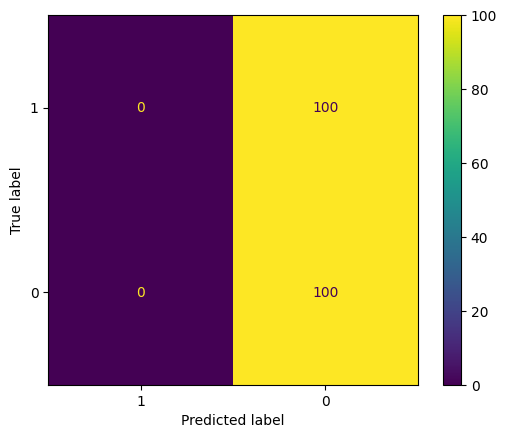

Epoch 2/50 | Train loss: 0.0122 | Valid loss: 0.0135 | Acc: 50.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       100
           0     0.5000    1.0000    0.6667       100

    accuracy                         0.5000       200
   macro avg     0.2500    0.5000    0.3333       200
weighted avg     0.2500    0.5000    0.3333       200



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

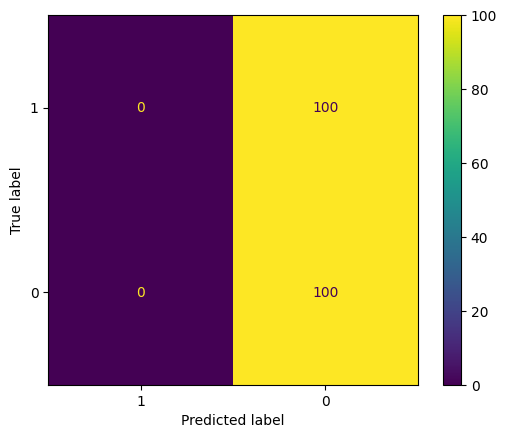

Epoch 3/50 | Train loss: 0.0113 | Valid loss: 0.0140 | Acc: 48.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.4908    0.8000    0.6084       100
           0     0.4595    0.1700    0.2482       100

    accuracy                         0.4850       200
   macro avg     0.4751    0.4850    0.4283       200
weighted avg     0.4751    0.4850    0.4283       200



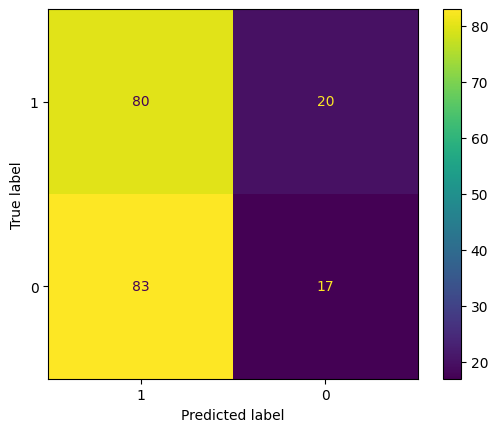

Epoch 4/50 | Train loss: 0.0111 | Valid loss: 0.0138 | Acc: 53.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5347    0.5400    0.5373       100
           0     0.5354    0.5300    0.5327       100

    accuracy                         0.5350       200
   macro avg     0.5350    0.5350    0.5350       200
weighted avg     0.5350    0.5350    0.5350       200



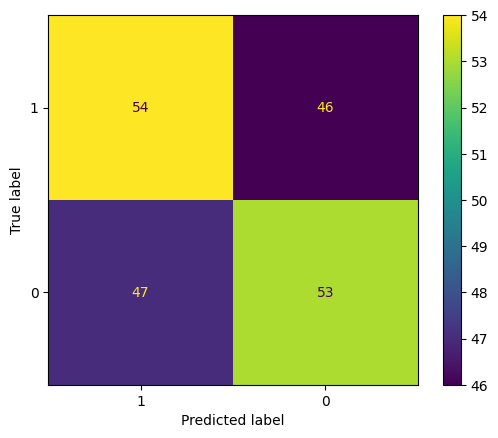

Epoch 5/50 | Train loss: 0.0110 | Valid loss: 0.0139 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5395    0.8200    0.6508       100
           0     0.6250    0.3000    0.4054       100

    accuracy                         0.5600       200
   macro avg     0.5822    0.5600    0.5281       200
weighted avg     0.5822    0.5600    0.5281       200



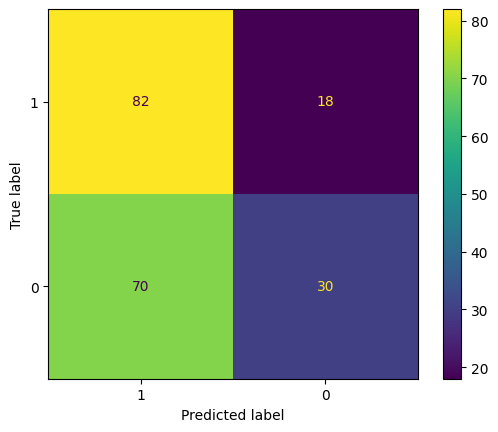

Epoch 6/50 | Train loss: 0.0110 | Valid loss: 0.0143 | Acc: 50.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5000    1.0000    0.6667       100
           0     0.0000    0.0000    0.0000       100

    accuracy                         0.5000       200
   macro avg     0.2500    0.5000    0.3333       200
weighted avg     0.2500    0.5000    0.3333       200



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

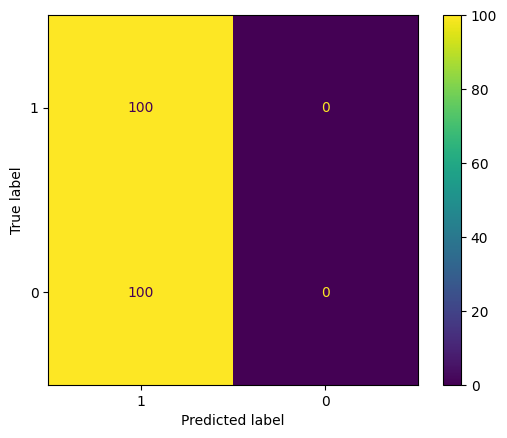

Epoch 7/50 | Train loss: 0.0110 | Valid loss: 0.0140 | Acc: 51.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5052    0.9800    0.6667       100
           0     0.6667    0.0400    0.0755       100

    accuracy                         0.5100       200
   macro avg     0.5859    0.5100    0.3711       200
weighted avg     0.5859    0.5100    0.3711       200



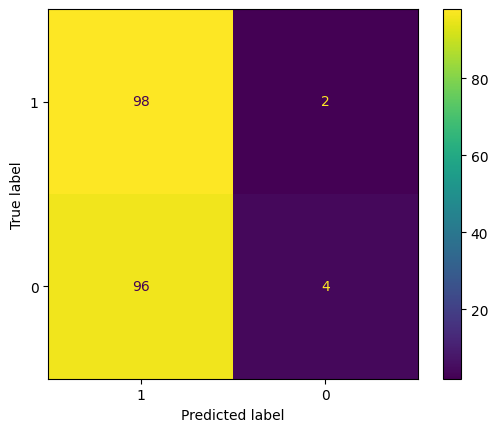

Epoch 8/50 | Train loss: 0.0110 | Valid loss: 0.0137 | Acc: 52.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5370    0.2900    0.3766       100
           0     0.5137    0.7500    0.6098       100

    accuracy                         0.5200       200
   macro avg     0.5254    0.5200    0.4932       200
weighted avg     0.5254    0.5200    0.4932       200



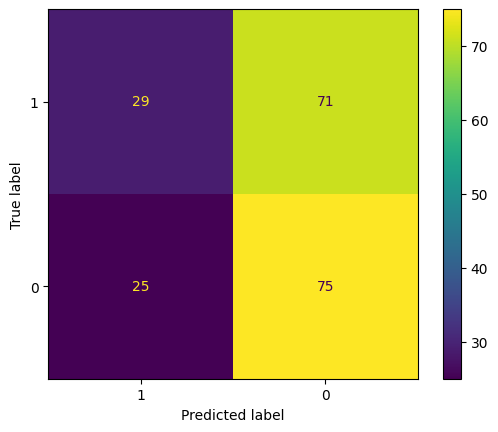

Epoch 9/50 | Train loss: 0.0110 | Valid loss: 0.0139 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5429    0.7600    0.6333       100
           0     0.6000    0.3600    0.4500       100

    accuracy                         0.5600       200
   macro avg     0.5714    0.5600    0.5417       200
weighted avg     0.5714    0.5600    0.5417       200



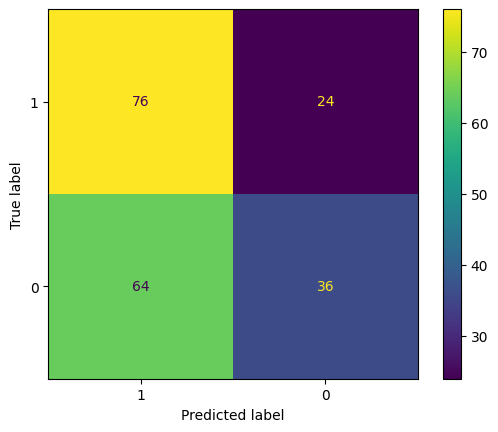

Epoch 10/50 | Train loss: 0.0110 | Valid loss: 0.0139 | Acc: 57.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5455    0.9000    0.6792       100
           0     0.7143    0.2500    0.3704       100

    accuracy                         0.5750       200
   macro avg     0.6299    0.5750    0.5248       200
weighted avg     0.6299    0.5750    0.5248       200



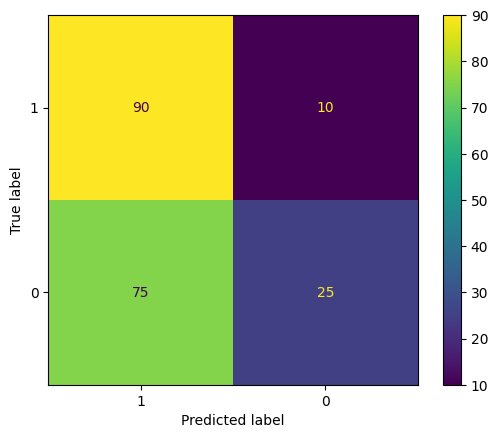

Epoch 11/50 | Train loss: 0.0110 | Valid loss: 0.0139 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5430    0.8200    0.6534       100
           0     0.6327    0.3100    0.4161       100

    accuracy                         0.5650       200
   macro avg     0.5878    0.5650    0.5347       200
weighted avg     0.5878    0.5650    0.5347       200



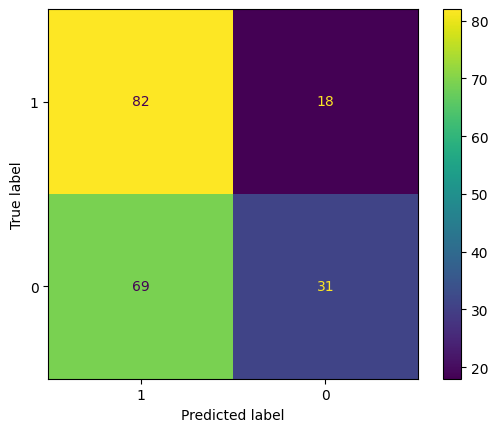

Epoch 12/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5474    0.7500    0.6329       100
           0     0.6032    0.3800    0.4663       100

    accuracy                         0.5650       200
   macro avg     0.5753    0.5650    0.5496       200
weighted avg     0.5753    0.5650    0.5496       200



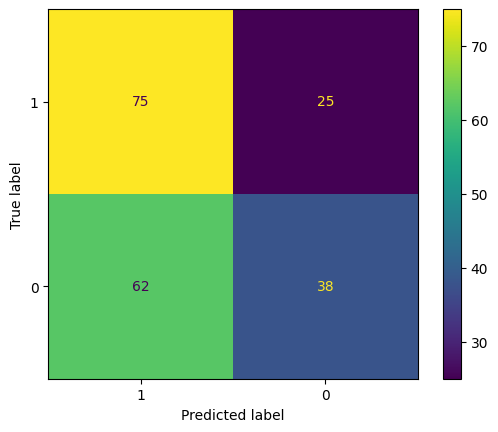

Epoch 13/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5474    0.7500    0.6329       100
           0     0.6032    0.3800    0.4663       100

    accuracy                         0.5650       200
   macro avg     0.5753    0.5650    0.5496       200
weighted avg     0.5753    0.5650    0.5496       200



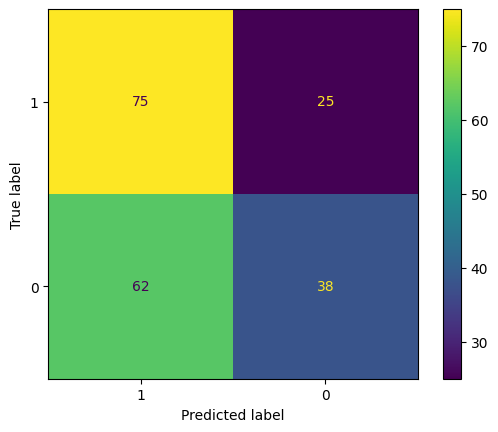

Epoch 14/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5455    0.7200    0.6207       100
           0     0.5882    0.4000    0.4762       100

    accuracy                         0.5600       200
   macro avg     0.5668    0.5600    0.5484       200
weighted avg     0.5668    0.5600    0.5484       200



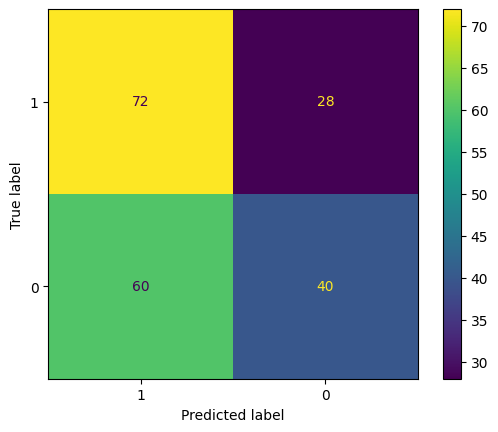

Epoch 15/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



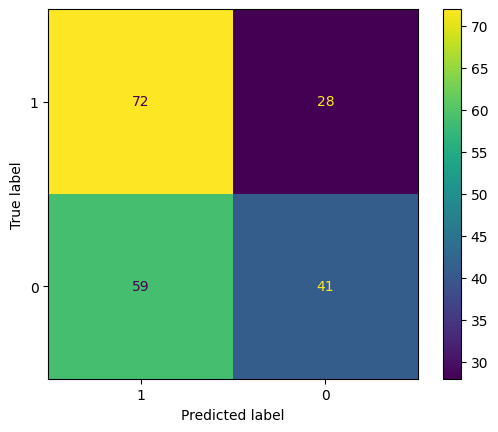

Epoch 16/50 | Train loss: 0.0109 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



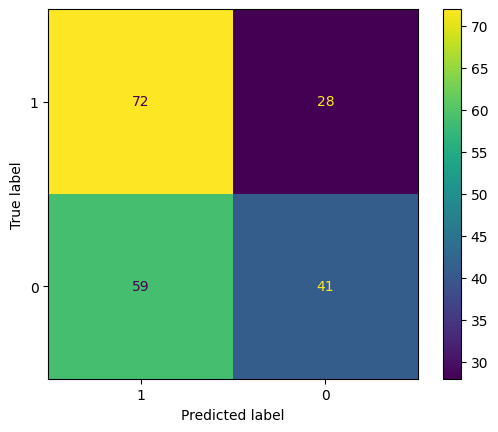

Epoch 17/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



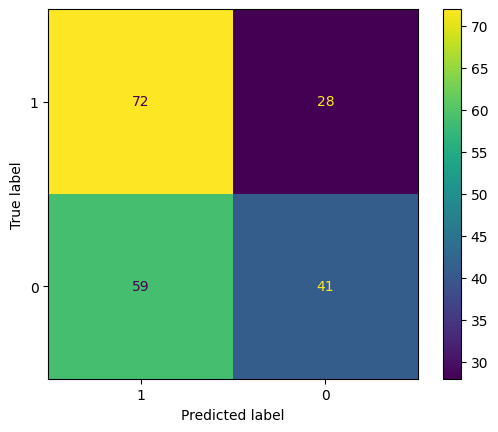

Epoch 18/50 | Train loss: 0.0109 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



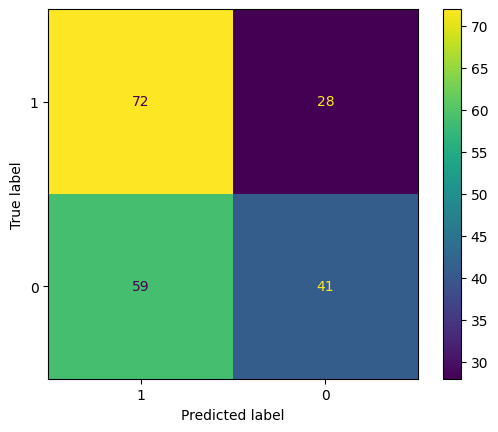

Epoch 19/50 | Train loss: 0.0109 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5462    0.7100    0.6174       100
           0     0.5857    0.4100    0.4824       100

    accuracy                         0.5600       200
   macro avg     0.5659    0.5600    0.5499       200
weighted avg     0.5659    0.5600    0.5499       200



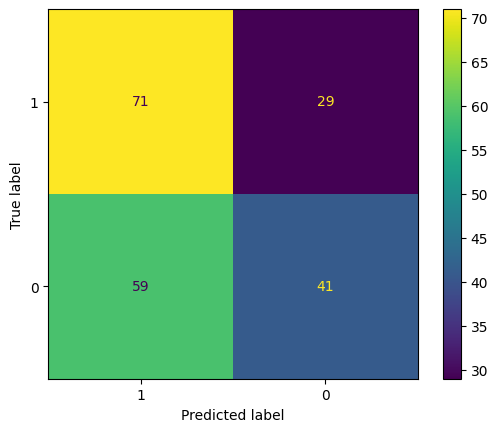

Epoch 20/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5462    0.7100    0.6174       100
           0     0.5857    0.4100    0.4824       100

    accuracy                         0.5600       200
   macro avg     0.5659    0.5600    0.5499       200
weighted avg     0.5659    0.5600    0.5499       200



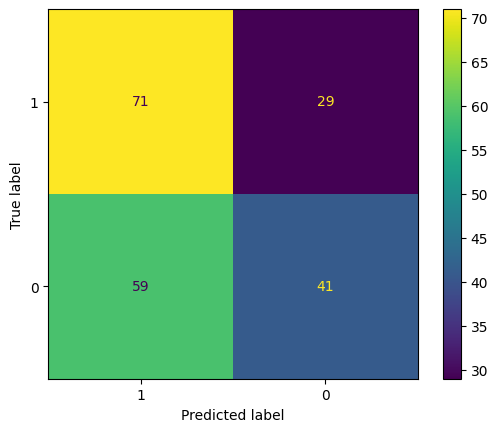

Epoch 21/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5462    0.7100    0.6174       100
           0     0.5857    0.4100    0.4824       100

    accuracy                         0.5600       200
   macro avg     0.5659    0.5600    0.5499       200
weighted avg     0.5659    0.5600    0.5499       200



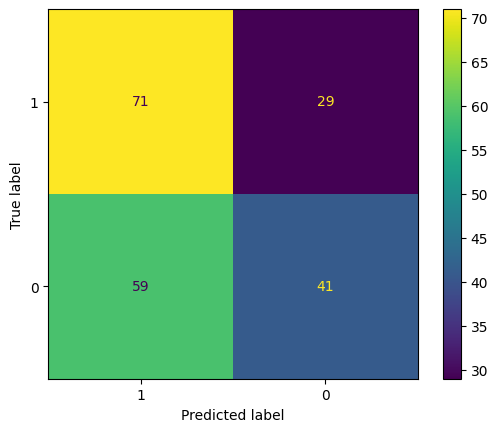

Epoch 22/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5462    0.7100    0.6174       100
           0     0.5857    0.4100    0.4824       100

    accuracy                         0.5600       200
   macro avg     0.5659    0.5600    0.5499       200
weighted avg     0.5659    0.5600    0.5499       200



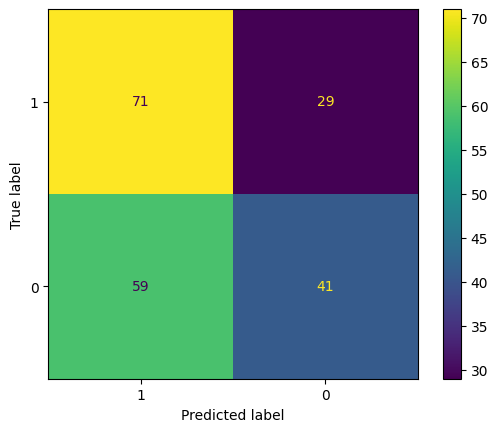

Epoch 23/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5462    0.7100    0.6174       100
           0     0.5857    0.4100    0.4824       100

    accuracy                         0.5600       200
   macro avg     0.5659    0.5600    0.5499       200
weighted avg     0.5659    0.5600    0.5499       200



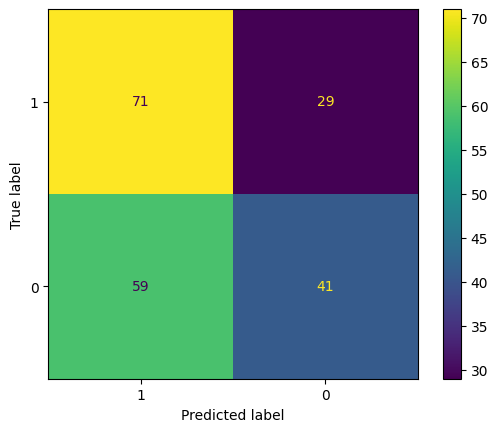

Epoch 24/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



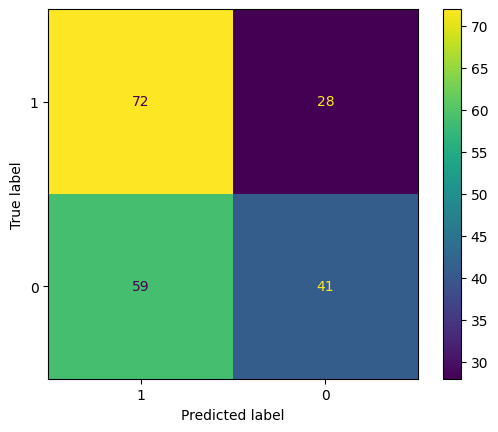

Epoch 25/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5462    0.7100    0.6174       100
           0     0.5857    0.4100    0.4824       100

    accuracy                         0.5600       200
   macro avg     0.5659    0.5600    0.5499       200
weighted avg     0.5659    0.5600    0.5499       200



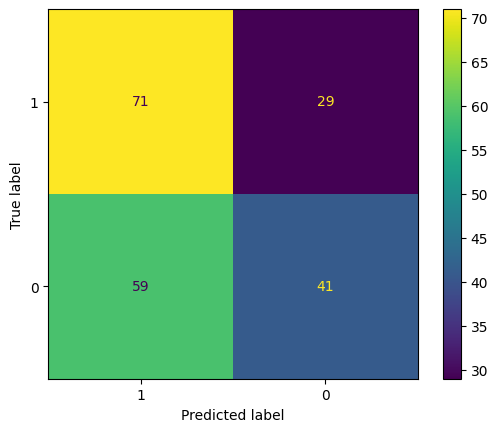

Epoch 26/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



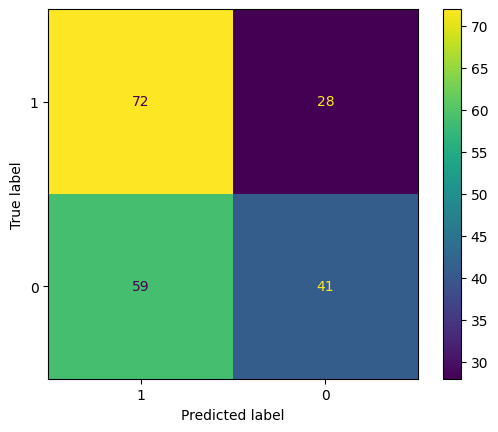

Epoch 27/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



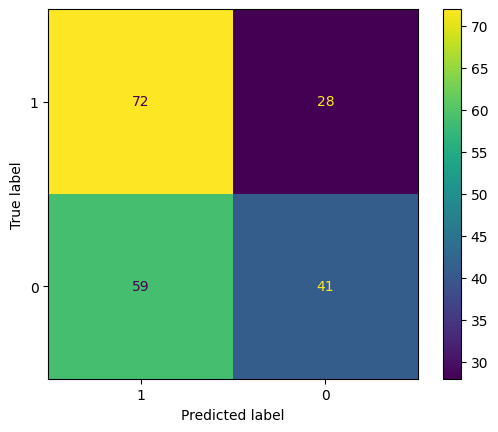

Epoch 28/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



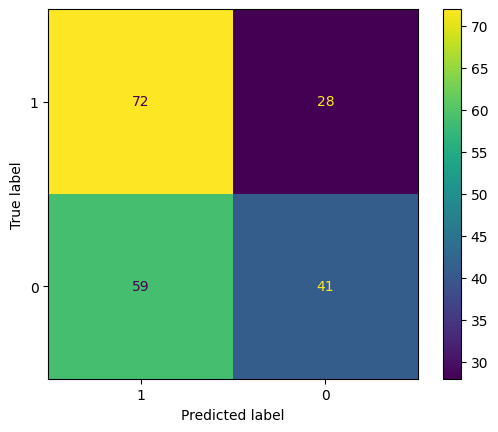

Epoch 29/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



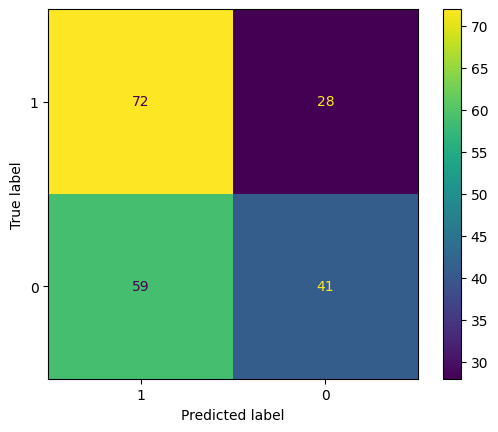

Epoch 30/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



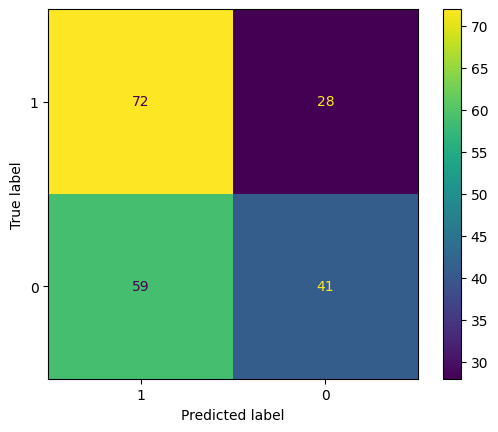

Epoch 31/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



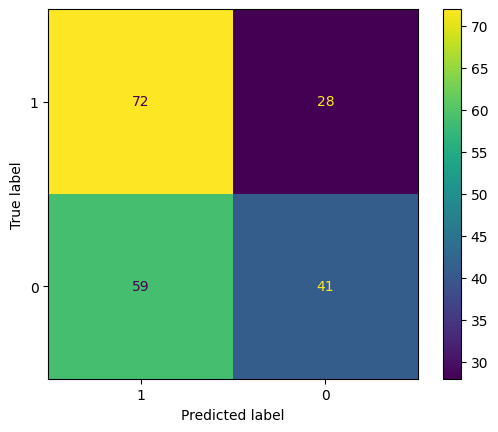

Epoch 32/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



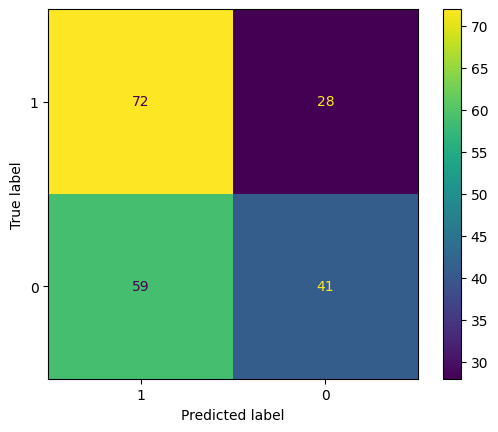

Epoch 33/50 | Train loss: 0.0109 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



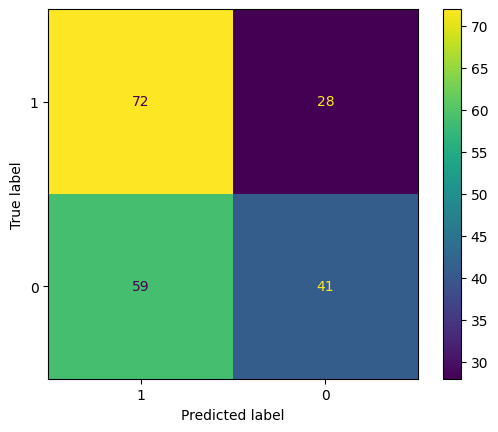

Epoch 34/50 | Train loss: 0.0110 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



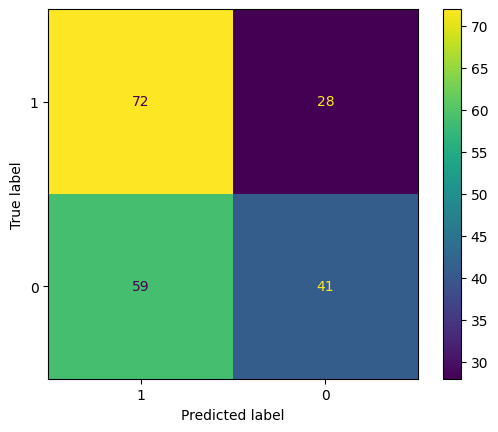

Epoch 35/50 | Train loss: 0.0109 | Valid loss: 0.0138 | Acc: 56.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5496    0.7200    0.6234       100
           0     0.5942    0.4100    0.4852       100

    accuracy                         0.5650       200
   macro avg     0.5719    0.5650    0.5543       200
weighted avg     0.5719    0.5650    0.5543       200



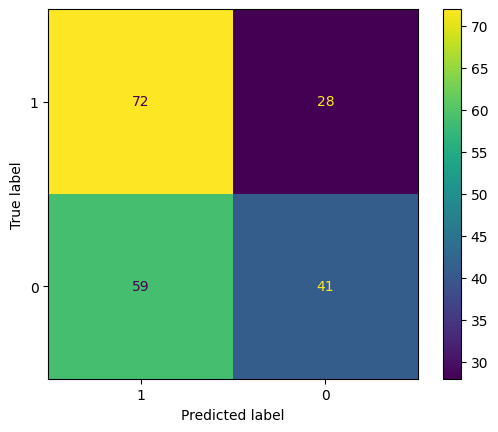

Early stopping...
Best model saved at epoch 15 with F1 score 0.5542918619841697


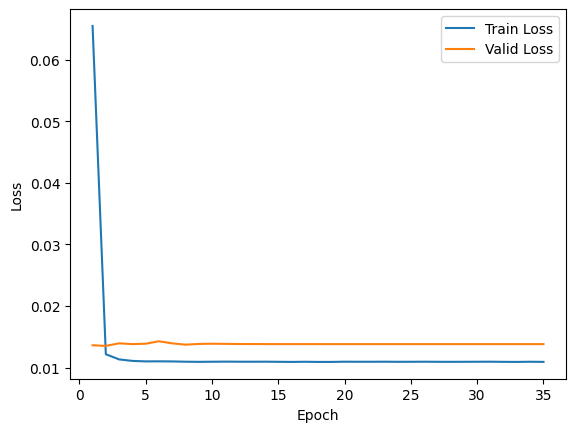

In [20]:
fit(cnn_model, 50)

In [21]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes,  pretrained_embeddings):
        super().__init__()
        
        # self.embed = nn.Embedding(vocab_size, embed_size)

        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings)
        
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)  # Replaced nn.GRU with nn.LSTM
        
        self.dropout = nn.Dropout(0.3)
        
        self.decision = nn.Linear(hidden_size, num_classes)
         
    def forward(self, x):
        x = x.to(device)
        embed = self.embed(x)
        
        output, (hidden, _) = self.rnn(embed)  # Unpack both hidden and cell state from LSTM
        
        drop = self.dropout(hidden[-1])  # Only consider the final hidden state
        
        return self.decision(drop.view(x.size(0), -1))
    # Set the embedding layer to non-trainable
cnn_model.embed.weight.requires_grad = False

In [22]:
lstm_model = RNN(vocab_size=len(token2int) + 1, embed_size=32, hidden_size=32, num_classes=len(Y_train.unique()),  pretrained_embeddings=embeddings)
lstm_model.to(device)


RNN(
  (embed): Embedding(5964, 32)
  (rnn): LSTM(32, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=32, out_features=2, bias=True)
)

Epoch 1/5 | Train loss: 0.0110 | Valid loss: 0.0137 | Acc: 54.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6216    0.2300    0.3358       100
           0     0.5276    0.8600    0.6540       100

    accuracy                         0.5450       200
   macro avg     0.5746    0.5450    0.4949       200
weighted avg     0.5746    0.5450    0.4949       200



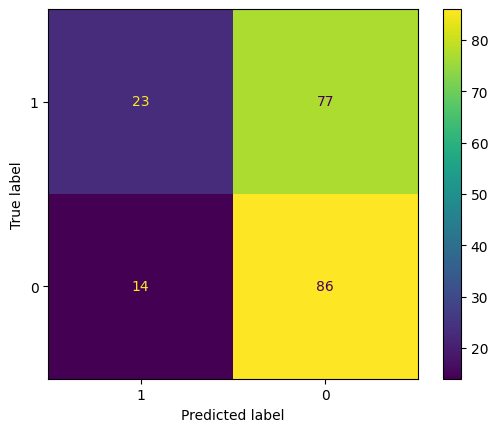

Epoch 2/5 | Train loss: 0.0110 | Valid loss: 0.0139 | Acc: 50.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5036    0.7000    0.5858       100
           0     0.5082    0.3100    0.3851       100

    accuracy                         0.5050       200
   macro avg     0.5059    0.5050    0.4854       200
weighted avg     0.5059    0.5050    0.4854       200



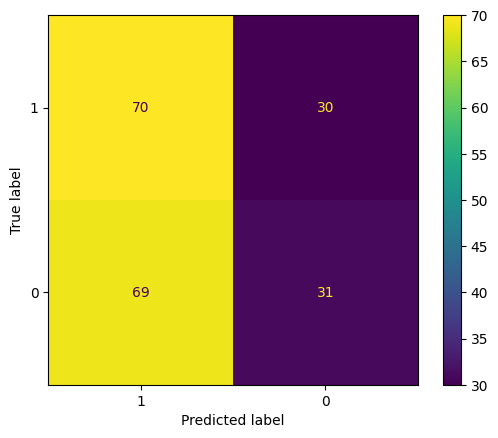

Epoch 3/5 | Train loss: 0.0109 | Valid loss: 0.0139 | Acc: 50.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5033    0.7600    0.6056       100
           0     0.5102    0.2500    0.3356       100

    accuracy                         0.5050       200
   macro avg     0.5068    0.5050    0.4706       200
weighted avg     0.5068    0.5050    0.4706       200



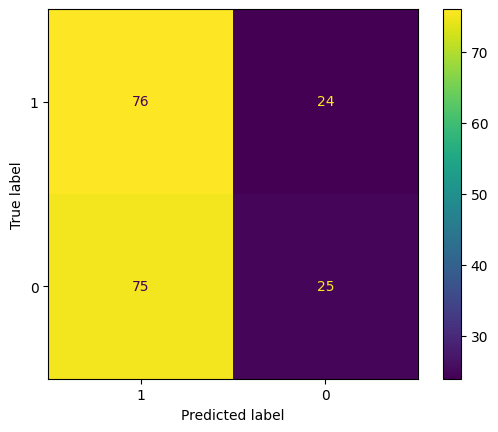

Epoch 4/5 | Train loss: 0.0109 | Valid loss: 0.0139 | Acc: 51.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5116    0.6600    0.5764       100
           0     0.5211    0.3700    0.4327       100

    accuracy                         0.5150       200
   macro avg     0.5164    0.5150    0.5046       200
weighted avg     0.5164    0.5150    0.5046       200



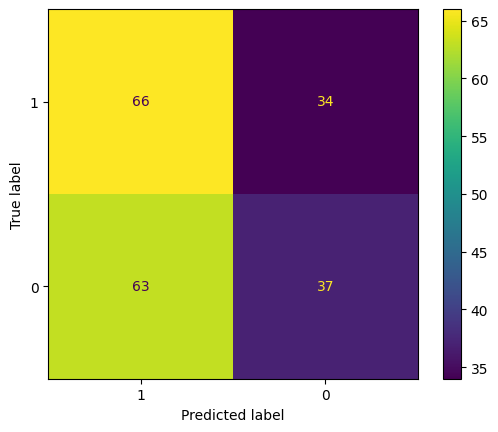

Epoch 5/5 | Train loss: 0.0109 | Valid loss: 0.0138 | Acc: 51.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5124    0.6200    0.5611       100
           0     0.5190    0.4100    0.4581       100

    accuracy                         0.5150       200
   macro avg     0.5157    0.5150    0.5096       200
weighted avg     0.5157    0.5150    0.5096       200



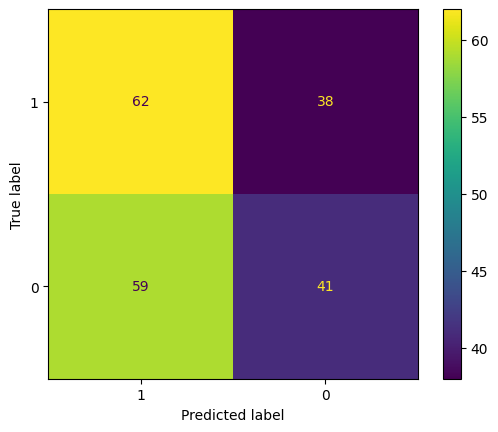

Best model saved at epoch 5 with F1 score 0.5095932657549482


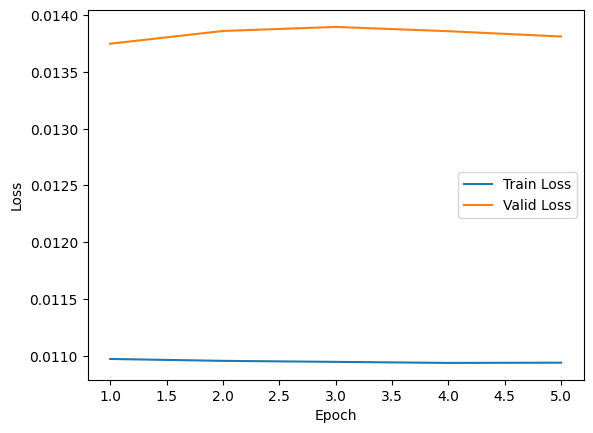

In [23]:
fit(lstm_model, 5)

## Reduce FastText demension

In [24]:
ft = fasttext.load_model('../Model/fasttext/cc.en.300.bin')
embed_size = ft.get_dimension()
pretrained_embeddings = fasttext.util.reduce_model(ft, 32)
ft.get_dimension()

32

In [151]:
ft.save_model('../Model/fasttext/cc.en.32.bin')